 #         CYCLE IDENTIFICATION BASED ON CNN ARCHITECTURE 
 ## Implemented using Keras with Tensorflow Backend


## PREPROCESSING 

In [96]:
import cv2
from imutils import paths
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
bike_folder = 'bike/'
none_folder = 'none/'
bikes =list(paths.list_images(bike_folder))
none = list(paths.list_images(none_folder))

## INPUT IMAGES

### Cycle Images

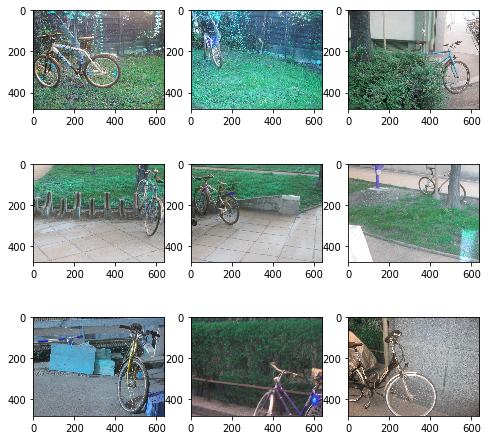

In [41]:
fig = plt.figure(figsize = (8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):

    image = cv2.imread(bikes[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)

plt.show()


## Negative Examples (Not a cycle)

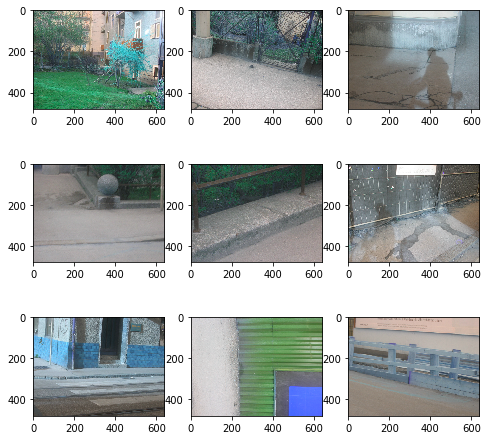

In [44]:
fig = plt.figure(figsize = (8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):

    image = cv2.imread(none[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)

plt.show()


In [85]:
files = bikes + none

# shuffling the input files
from random import shuffle
random.seed(4)
shuffle(training_files)

from keras.utils import to_categorical
# image is labelled  1 if bike else labelled 0 
labels = [ 1 if "bike" in training_file else 0  for training_file in training_files]

print(f"Before one hot encoding: {labels[0]}")

# one hot encoding, done to vectorize the labels
labels = to_categorical(labels)

print(f"After one hot encoding: {labels[0]}")


Before one hot encoding: 0
After one hot encoding: [1. 0.]


## Helper Functions

###  For preprocessing image file to get numpy array and to load the image data into memory

### NOTE: DON'T TRY TO LOAD HUGE IMAGE DATASETS INTO MEMORY! USE HD5PY TO SAVE THOSE ARRAYS! 

In [77]:
def imgtoarray(file):
    
    # reading the file
    image = cv2.imread(file)
    # converting all the images to 300x300 size
    image = cv2.resize(image, (300, 300))
    # normalising the image data range to 0 to 1
    image = image/255
    # the normalised data is returned
    return image

def image_to_memory(train_x_files, test_x_files):
    train_x =  []
    test_x = [] 
    # training_image files' data are pushed into memory
    for file in train_x_files:
        train_x.append(imgtoarray(file))
    
    # testing_image files' data are pushed into memory
    for file in test_x_files:
        test_x.append(imgtoarray(file))
    
    return np.array(train_x), np.array(test_x)


In [83]:
# The training and testing files are split according to the ratio
def train_test_splitter(dataset, ratio= 0.7):

    total_points = len(dataset[0])
    train_size = int(ratio*total_points)
    train_x = dataset[0][:train_size]
    train_y = dataset[1][:train_size]
    test_x = dataset[0][train_size:]
    test_y = dataset[1][train_size:]
    return train_x, train_y, test_x, test_y

In [93]:
# Generating the dataset
dataset = [files, labels]
# the files are split into test and training data
train_x_files, train_y, test_x_files, test_y = train_test_splitter(dataset)
# the images are loaded onto the memory
train_x, test_x = image_to_memory(train_x_files, test_x_files)


In [95]:
print(f" Total number of samples in training set : {train_x.shape[0]}")
print(f" Total number of samples in test set : {test_x.shape[0]} ")
print(f" Dimensions of training data is : {train_x.shape}")
print(f" Dimensions of test data is : {test_x.shape}")

 Total number of samples in training set : 521
 Total number of samples in test set : 224 
 Dimensions of training data is : (521, 300, 300, 3)
 Dimensions of test data is : (224, 300, 300, 3)


# Training the CNN Model 

In [113]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras import optimizers

class Net():
    @staticmethod
    def build():
        #image dimensions
        input_dim = (300, 300, 3)
        model = Sequential()
        
        # layer1 CONV -> POOL -> ACTIVATION
        model.add(Conv2D(12, kernel_size = 5, padding = 'same',
         input_shape = input_dim))
        model.add(MaxPooling2D(pool_size= (2,2), strides = 2)) 
        model.add(Activation('relu'))

        #layer2 CONV -> POOL -> FLATTEN
        model.add(Conv2D(24, kernel_size = 5, padding = 'same'))
        model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
        model.add(Flatten())

        #FULLY CONNECTED LAYERS
#         model.add(Dense(500))
#         model.add(Activation('relu'))

        model.add(Dense(250))
        model.add(Activation('relu'))

        model.add(Dropout(0.4))

        # 2 class classification
        # vector [1 0] -> Not a bike
        # vector [0 1] -> It's a bike
        model.add(Dense(2))
        model.add(Activation('softmax'))
        return model 

model = Net.build()
print("Model Architecture:")
model.summary()

Model Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 300, 300, 12)      912       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 150, 150, 12)      0         
_________________________________________________________________
activation_20 (Activation)   (None, 150, 150, 12)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 150, 150, 24)      7224      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 24)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 135000)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 250)               3

In [116]:
# Adam Optimizer is used for training this model
sgd = optimizers.SGD(lr = 0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, 
             metrics = ['accuracy'])